<a href="https://colab.research.google.com/github/yasinsoylu1997/age-gender/blob/main/age_gender_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import tensorflow as tf


In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
df = pd.read_csv('/content/drive/MyDrive/age_gender.csv')

In [53]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [54]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,23705.0,33.300907,19.885708,1.0,23.0,29.0,45.0,116.0
ethnicity,23705.0,1.269226,1.345638,0.0,0.0,1.0,2.0,4.0
gender,23705.0,0.477283,0.499494,0.0,0.0,0.0,1.0,1.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


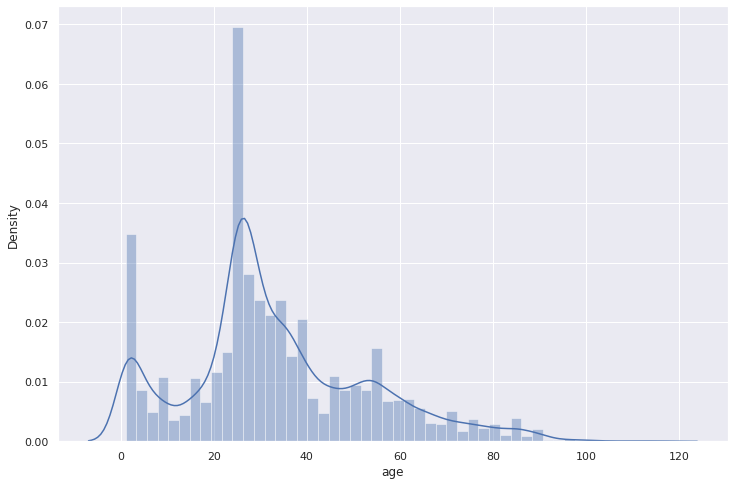

In [55]:
plt.figure(figsize=(12,8))
sns.distplot(df['age']);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


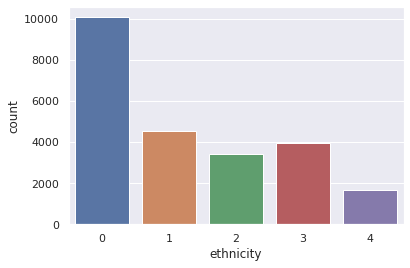

In [56]:
sns.countplot(df['ethnicity']);


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


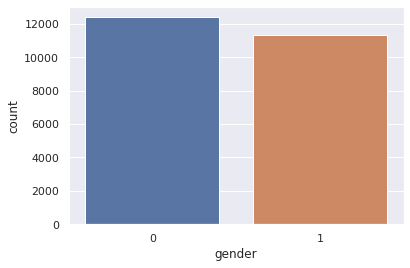

In [57]:
sns.countplot(df['gender']);


In [58]:
df['pixels'] = df['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))

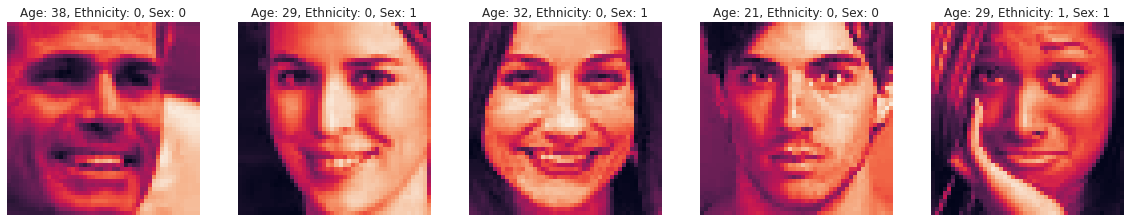

In [59]:
# Plot some pictures
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    random_face = np.random.choice(len(df))
    
    age = df['age'][random_face]
    ethnicity = df['ethnicity'][random_face]
    gender = df['gender'][random_face]
    
    axes[i].set_title('Age: {0}, Ethnicity: {1}, Sex: {2}'.format(age, ethnicity, gender))
    axes[i].imshow(df['pixels'][random_face])
    axes[i].axis('off')

# Age prediction¶


In [60]:
X = np.array(df['pixels'].to_list())
X_reshaped = X.reshape(X.shape[0], 48, 48, 1)

In [61]:
if np.max(X_reshaped) > 1: X_reshaped = X_reshaped / 255


In [62]:
input_shape = X_reshaped.shape[1:] 

In [63]:
y = df['age'].values


In [124]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_reshaped)

In [125]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [126]:
age_model = Sequential()

age_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(BatchNormalization())

age_model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.3))
age_model.add(BatchNormalization())

age_model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.3))
age_model.add(BatchNormalization())


age_model.add(Flatten())
age_model.add(Dense(128, activation='relu'))
age_model.add(Dropout(0.4))
age_model.add(Dense(1))

age_model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mae'])

age_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_30 (Bat  (None, 23, 23, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_49 (Conv2D)          (None, 23, 23, 64)        36928     
                                                                 
 conv2d_50 (Conv2D)          (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 10, 10, 64)     

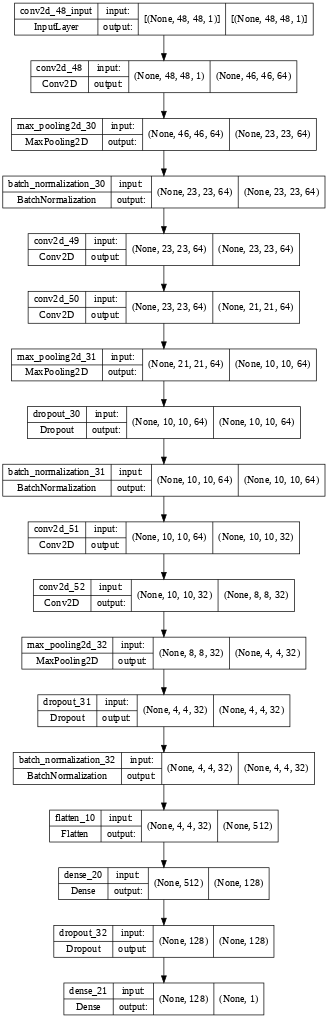

In [127]:
from keras.utils.vis_utils import plot_model

plot_model(age_model, to_file='age_model.png', show_shapes=True, show_layer_names=True,dpi=50)

In [128]:
#!pip install visualkeras


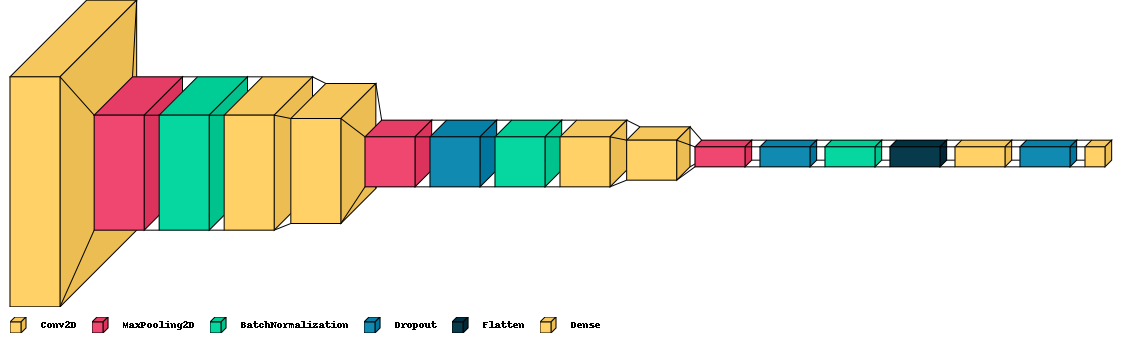

<Figure size 144x144 with 0 Axes>

In [129]:
import visualkeras
from PIL import ImageFont
plt.figure(figsize=(2, 2))
visualkeras.layered_view(age_model, legend=True,spacing=15,scale_xy = 5 , scale_z = 10, max_z = 50) 

In [133]:
n_epochs = 30
batch_size = 32

In [134]:
checkpoint = ModelCheckpoint("cnn.h5",monitor="val_loss",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_delta = 0.0001,mode='auto',verbose=1)
early_stop=tf.keras.callbacks.EarlyStopping( monitor="val_loss",patience=10,verbose=1,mode="auto")           

In [135]:
history = age_model.fit(X_train, y_train, 
                        epochs=n_epochs,
                        batch_size=batch_size,
                        callbacks=[checkpoint,reduce_lr,early_stop],
                        validation_data=(X_test, y_test))

Epoch 1/30
589/593 [============================>.] - ETA: 0s - loss: 0.1947 - mae: 0.3727
Epoch 1: val_loss improved from inf to 0.15313, saving model to cnn.h5
593/593 [==============================] - 5s 9ms/step - loss: 0.1944 - mae: 0.3724 - val_loss: 0.1531 - val_mae: 0.3278 - lr: 0.0010
Epoch 2/30
587/593 [============================>.] - ETA: 0s - loss: 0.1483 - mae: 0.3136
Epoch 2: val_loss did not improve from 0.15313
593/593 [==============================] - 5s 8ms/step - loss: 0.1484 - mae: 0.3138 - val_loss: 0.2273 - val_mae: 0.3843 - lr: 0.0010
Epoch 3/30
592/593 [============================>.] - ETA: 0s - loss: 0.1298 - mae: 0.2861
Epoch 3: val_loss improved from 0.15313 to 0.10394, saving model to cnn.h5
593/593 [==============================] - 5s 8ms/step - loss: 0.1298 - mae: 0.2861 - val_loss: 0.1039 - val_mae: 0.2384 - lr: 0.0010
Epoch 4/30
591/593 [============================>.] - ETA: 0s - loss: 0.1175 - mae: 0.2665
Epoch 4: val_loss improved from 0.10394 t

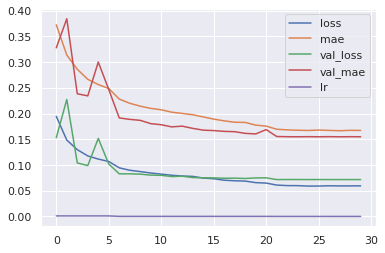

In [136]:
pd.DataFrame(history.history).plot();

In [138]:
valid_score = age_model.evaluate(X_test, y_test, verbose=1)

149/149 [==============================] - 1s 4ms/step - loss: 0.0716 - mae: 0.1548


In [139]:
y_pred = age_model.predict(X_test)

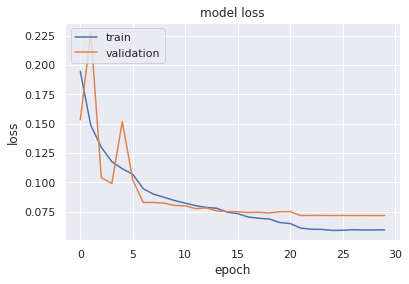

In [140]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

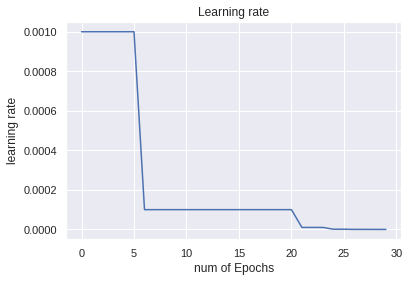

In [141]:
nb_epoch = len(history.history['loss'])
learning_rate=history.history['lr']
xc=range(nb_epoch)
plt.plot(xc,learning_rate)
plt.xlabel('num of Epochs')
plt.ylabel('learning rate')
plt.title('Learning rate')
plt.grid(True)
plt.style.use(['seaborn-ticks'])


# Gender prediction¶


In [142]:
y = df['gender'].values
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [115]:
gender_model = Sequential()

gender_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(BatchNormalization())

gender_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
#gender_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.4))
gender_model.add(BatchNormalization())

gender_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
gender_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.5))
gender_model.add(BatchNormalization())

gender_model.add(Flatten())

gender_model.add(Dense(64, activation='relu'))
gender_model.add(Dropout(0.4))

gender_model.add(Dense(1, activation='sigmoid')) #For binary classification activation function is sigmoid 

gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #...and loss function is binary_crossentropy

gender_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_27 (Bat  (None, 23, 23, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_45 (Conv2D)          (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 10, 10, 128)      0         
 g2D)                                                            
                                                      

In [148]:
# Callbacks for gender model
callbacks = [EarlyStopping(patience=10, monitor='val_accuracy', mode='max'), 
              ReduceLROnPlateau(patience=5, verbose=1)]

In [149]:
history = gender_model.fit(X_train, y_train, 
                           epochs=n_epochs,
                           batch_size=batch_size,
                           callbacks=callbacks,
                           validation_data=(X_test, y_test))

Epoch 1/30
593/593 [==============================] - 6s 10ms/step - loss: 0.1438 - accuracy: 0.9393 - val_loss: 0.2422 - val_accuracy: 0.9082 - lr: 1.0000e-11
Epoch 2/30
593/593 [==============================] - 5s 9ms/step - loss: 0.1449 - accuracy: 0.9410 - val_loss: 0.2422 - val_accuracy: 0.9085 - lr: 1.0000e-11
Epoch 3/30
593/593 [==============================] - 5s 9ms/step - loss: 0.1459 - accuracy: 0.9397 - val_loss: 0.2423 - val_accuracy: 0.9085 - lr: 1.0000e-11
Epoch 4/30
593/593 [==============================] - 5s 9ms/step - loss: 0.1424 - accuracy: 0.9404 - val_loss: 0.2421 - val_accuracy: 0.9082 - lr: 1.0000e-11
Epoch 5/30
593/593 [==============================] - 5s 9ms/step - loss: 0.1445 - accuracy: 0.9402 - val_loss: 0.2423 - val_accuracy: 0.9085 - lr: 1.0000e-11
Epoch 6/30
593/593 [==============================] - ETA: 0s - loss: 0.1428 - accuracy: 0.9383
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.
593/593 [=======================

In [150]:
valid_score = gender_model.evaluate(X_test, y_test, verbose=1)
print('Accuracy for test set: {0}'.format(valid_score[1]))

149/149 [==============================] - 1s 4ms/step - loss: 0.2427 - accuracy: 0.9082
Accuracy for test set: 0.9082472324371338


In [146]:
y_pred = gender_model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

In [147]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.91      0.91      2468
           1       0.90      0.91      0.91      2273

    accuracy                           0.91      4741
   macro avg       0.91      0.91      0.91      4741
weighted avg       0.91      0.91      0.91      4741



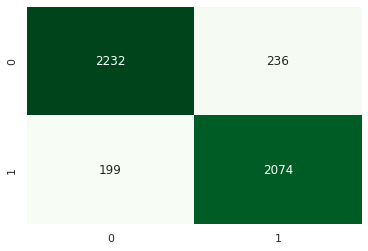

In [121]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Greens', cbar=False, annot=True, fmt='d');